# Scalable Graph Learning

GCN and GAT, although fantastic designs, have two issues:
- scaling to large graphs 
- inefficiently in generalizing to unseen data

Traditional GCNs are designed to process the **entire** graph simultaneously during training and inference. This approach is known as full-batch training. Moreover, GCNs operate on the adjacency matrix $𝐴$ and the feature matrix $X$ of the entire graph. 

GraphSAGE (Graph Sample and Aggregate) addresses the scalability issues of GCNs by introducing a method to perform mini-batch training on graphs. By *sampling neighbors* and constructing *mini-batches*, GraphSAGE allows for efficient training on large graphs. This method significantly reduces memory usage and computational cost.

#### Constructing mini-batches

Graph Convolutional Networks (GCNs) generate embeddings for *all* nodes in the graph simultaneously. To achieve this, GCNs load the entire adjacency matrix $A$ and the node feature matrix $X$. At each layer of the network, GCNs compute the embeddings of all nodes by aggregating the embeddings from the previous layer. This process continues layer by layer until the final layer, where the model computes the loss and performs *full-batch* gradient descent to update the weights.

However, full-batch implementation is not feasible for large graphs due to several limitations. One primary issue is the constrained memory capacity of GPUs, which we utilize for accelerated training. Since GPU memory is limited, it becomes impractical to load the entire graph structure and all node features into GPU memory simultaneously. This limitation necessitates alternative approaches to handle large-scale graphs efficiently.

<u>**Key insight: To compute embedding of a single node, all we need is the K-hop neighborhood**</u>

Instead of processing the entire graph at once, GraphSAGE proposes to select mini-batches of M nodes from the graph for training. These are the target nodes for which embeddings will be computed. Given a set of M different nodes in a mini-batch, we can generate each node's embeddings using a smaller subgraph which involves neighbors up to K-hops away.


<div style="display: flex; align-items: flex-end;">
    <div style="flex: 1; padding: 5px;">
        <img src="images/2hops.png" alt="Image 1" style="max-width: 100%;">
        <p style="text-align: center;">1-hop and 2-hop neighbors of node 0</p>
    </div>
    <div style="flex: 1; padding: 5px;">
        <img src="images/2hopes_cg.png" alt="Image 2" style="max-width: 100%;">
        <p style="text-align: center;">A computation graph for node 0</p>
    </div>
</div>
<center><small>images from https://web.stanford.edu/class/cs224w/slides/15-scalable.pdf</small></center>

However, the computations can become exponentially large with respect to the layer size K (depicted in Figure a) or explodes when it hits a hub node (high-degree node, such as celebrities with lots of followers in social networks).

We have to make each subgraph more *"compact"*. Sample a **fixed number of neighbors** for each node. This sampling is performed layer by layer, ensuring that the computation remains manageable.

<center><img src="images/2hop_sampling.png" width=500></center>
<center><small>neighbor sampling to keep two 1-hop neighbors and two 2-hop neighbors</small></center>
GraphSAGE aggregates information from the sampled neighbors using functions like mean, LSTM, or pooling. The aggregation ensures that the representation of each node is influenced by its local neighborhood:

\begin{equation*}
$h^k_{mathcal{N}_v} \leftarrow AGGREGATE_k
\end{equation*}
.
Mini-Batch Training:



c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\utils\convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  data_dict[key] = torch.as_tensor(value)
c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\networkx\drawing\nx_pylab.py:305: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowsize.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


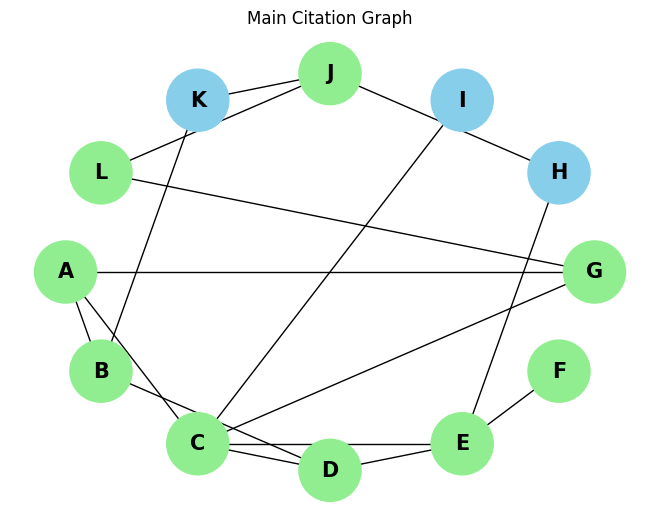

('A', {'feature': array([0.48848155, 0.64586772, 0.47413372]), 'label': 1, 'train_mask': True})
('B', {'feature': array([0.55411241, 0.73383481, 0.87953207]), 'label': 1, 'train_mask': True})
('C', {'feature': array([0.5409718 , 0.40844945, 0.0274274 ]), 'label': 0, 'train_mask': True})
('D', {'feature': array([0.92577185, 0.00548691, 0.3671017 ]), 'label': 1, 'train_mask': True})
('E', {'feature': array([0.89840446, 0.10685655, 0.9528334 ]), 'label': 0, 'train_mask': True})
('F', {'feature': array([0.07818705, 0.67402095, 0.68059703]), 'label': 0, 'train_mask': True})
('G', {'feature': array([0.82755573, 0.41625278, 0.51797986]), 'label': 1, 'train_mask': True})
('H', {'feature': array([0.65759292, 0.92067323, 0.45473874]), 'label': 0, 'train_mask': False})
('I', {'feature': array([0.3449232 , 0.71452432, 0.45877133]), 'label': 0, 'train_mask': False})
('J', {'feature': array([0.38088047, 0.85465696, 0.59987755]), 'label': 0, 'train_mask': True})
('K', {'feature': array([0.87794611, 0

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx, to_networkx


# Define the graph structure
nodes = ['A', 'B', 'C', 'D', 'E', 'F','G','H','I','J','K','L']
edges = [('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'D'), ('C', 'E'), ('D', 'E'), ('E', 'F'),('G','A'),('G','C'),('H','E'),('I','C'),('J','K'),('K','B'),('L','G'),('L','J'), ('J','H')]

# Create a NetworkX directed graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Assign random features, labels, and train_mask to nodes
features = {node: np.random.rand(3) for node in nodes}
labels = {node: np.random.randint(2) for node in nodes}
train_mask = {node: np.random.rand() < 0.5 for node in nodes}

# Add attributes to the graph
nx.set_node_attributes(G, features, 'feature')
nx.set_node_attributes(G, labels, 'label')
nx.set_node_attributes(G, train_mask, 'train_mask')

# Convert NetworkX graph to PyTorch Geometric Data object
data = from_networkx(G)
data.x = torch.tensor([features[node] for node in nodes], dtype=torch.float)
data.y = torch.tensor([labels[node] for node in nodes], dtype=torch.long)
data.train_mask = torch.tensor([train_mask[node] for node in nodes], dtype=torch.bool)
data.edge_index = torch.tensor([(nodes.index(u), nodes.index(v)) for u, v in edges], dtype=torch.long).t().contiguous()

# Create DataLoader
#data_list = [data] * 10  # For demonstration, using the same graph multiple times
#train_loader = DataLoader(data_list, batch_size=2, shuffle=True)
from torch_geometric.loader import NeighborLoader
train_loader = NeighborLoader(
data,
num_neighbors=[2,2],
batch_size=2,
input_nodes=data.train_mask,
)
# Function to visualize a graph
def visualize_graph(G, title):
    pos = nx.shell_layout(G)
    train_mask_color = ['lightgreen' if G.nodes[node[0]]['train_mask'] else 'skyblue' for node in G.nodes]
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color=train_mask_color, font_size=15, font_weight='bold', arrowsize=20)
    plt.title(title)
    plt.show()

    # Print node attributes
    for node in G.nodes(data=True):
        print(node)

# Visualize the main graph
visualize_graph(G, 'Main Citation Graph')

# Visualize subgraphs from the DataLoader
d1 = dict(enumerate(nodes))
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {[d1[node.item()] for node in subgraph.input_id]}')
    print(f'Subgraph {i}: {[d1[node.item()] for node in subgraph.n_id]}')

